In [13]:
import pandas as pd
import numpy as np

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)

SEX: пол клиента (1 = мужской, 2 = женский )

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

AGE: возраст в годах

PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)

BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь

PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре

default - индикатор невозврата денежных средств

In [170]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 1. Задание.

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

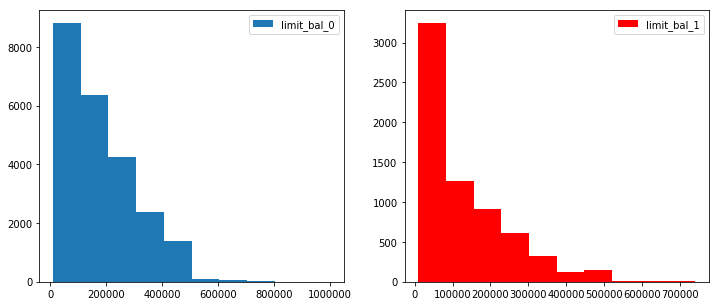

In [11]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default == 0]['LIMIT_BAL'], label = 'limit_bal_0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default == 1]['LIMIT_BAL'], color = 'r', label = 'limit_bal_1')
pylab.legend()

pylab.show()

In [85]:
data['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

По гистограммам сложно что-то сказать про распределение, поэтому для проверки будет использовать не параметрические критерии.

Также разница в количестве данных довольна большая: большинство людей вернули кредит. Следовательно, для интервальной оценки будем использовать метод бутсрепа.

$H_0$ - медианы для кредитного лимита равны для людей, вернувших кредит и не вернувших.

Проверяем в стороны двухсторонней альтернативы $H_1$ - медианы не равны.

In [83]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [93]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / float(2), 100 * (1 - alpha / float(2))])
    return boundaries

In [96]:
np.random.seed(0)

median_0 = map(np.median, get_bootstrap_samples(data[data.default == 0]['LIMIT_BAL'].values, 1000))
median_1 = map(np.median, get_bootstrap_samples(data[data.default == 1]['LIMIT_BAL'].values, 1000))

In [97]:
print "difference between medians:", np.median(median_0) - np.median(median_1)

difference between medians: 60000.0


In [98]:
delta_median = map(lambda x: x[1] - x[0], zip(median_0, median_1))

In [99]:
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median, 0.05)

95% confidence interval for the difference between medians [-70000. -60000.]


Доверительный интервал не содержит 0. Нулевая гипотеза отвергается.
б) проверим гипотезу о равенстве распределений с помощью рангового критерия Манна-Уитни (так как выборки независимые и в каждой выборке больше 10 объектов), предполагая, что распределения, из которых взяты выборки, полностью совпадают против альтернативы сдвига.

In [109]:
stats.mannwhitneyu(data[data.default == 0]['LIMIT_BAL'], data[data.default == 1]['LIMIT_BAL'])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

p-value очнь маленькое, следовательно, нулевая гипотеза о равенстве распределений отвергается в сторону двусторонней альтернативы.

Полученные результаты значимы: кредитный лимит людей, не вернувших кредит в среднем ниже. Действительно, банку выгоднее давать большие суммы денег тем, в ком он уверен и наоборот.

## 2. Задание.

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.

$H_0$ - гендерный состав группы людей вернувших и не вернувших кредит не отличается.

$H_1$ - гендерный состав группы людей вернувших и не вернувших кредит отличается.


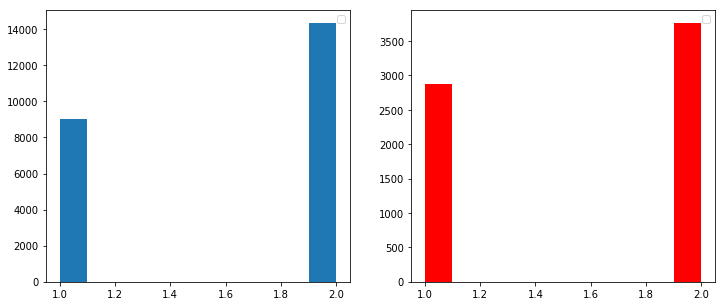

In [19]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default == 0]['SEX'])
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default == 1]['SEX'], color = 'r')
pylab.legend()

pylab.show()

По гистограммам сложно что-то сказать.

Проверим нулевую гипотезу с помощью доверительного интервала. Сформулируем ее немного по другому: доля женщин среди тех, кто вернул и не вернул кредит одинаковая (проверяется в сторону двухсторонней альтернативы).

In [20]:
from statsmodels.stats.proportion import proportion_confint

In [34]:
women_0 = data[data.default == 0][data['SEX'] == 2].shape[0]
women_1 = data[data.default == 1][data['SEX'] == 2].shape[0]

C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [35]:
sum_0 = data[data.default == 0].shape[0]
sum_1 = data[data.default == 1].shape[0]

In [38]:
conf_interval_0 = proportion_confint(women_0, sum_0,
                                            method = 'wilson')
conf_interval_1 = proportion_confint(women_1, sum_1,
                                            method = 'wilson')

In [39]:
print '95%% confidence interval for a click probability, banner a: [%f, %f]' % conf_interval_0
print '95%% confidence interval for a click probability, banner b [%f, %f]' % conf_interval_1

95% confidence interval for a click probability, banner a: [0.607890, 0.620373]
95% confidence interval for a click probability, banner b [0.555102, 0.578938]


Доверительные интервалы не пересекаются, следовательно, можем сделать вывод, что нулевая гипотеза отвергается и доля женщин, среди тех, кто вернул кредит, не равна доли женщин среди тех, кто не врнул кредит.

Также по доверительному интервалу можем сказать, что доля женщин в группе вернувших больше. То есть пол влияет на факт возврата.

Теперь оценим с помощью Z-критерия о разности долей в двух независимых выборках:

In [41]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [48]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [49]:
sample_1 = data[data.default == 0]['SEX'].apply(lambda x: 1 if x == 2 else 0)
sample_2 = data[data.default == 1]['SEX'].apply(lambda x: 1 if x == 2 else 0)

In [50]:
proportions_diff_z_test(proportions_diff_z_stat_ind(sample_1, sample_2))

4.472866521609831e-12

Достигаемый уровень значимости очень мал, следовательно, на уровне доверия 0.05 нулевая гипотеза уверенно отвергается в сторону двусторонней альтернативы.

А в сторону односторонней?

In [52]:
proportions_diff_z_test(proportions_diff_z_stat_ind(sample_1, sample_2), alternative = 'greater')

2.2364332608049153e-12

Также отвергается. Можем сделать вывод, что доля женщин среди людей, вернувших кредит больше, чем среди не вернувших.

## 3. Задание.

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [111]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

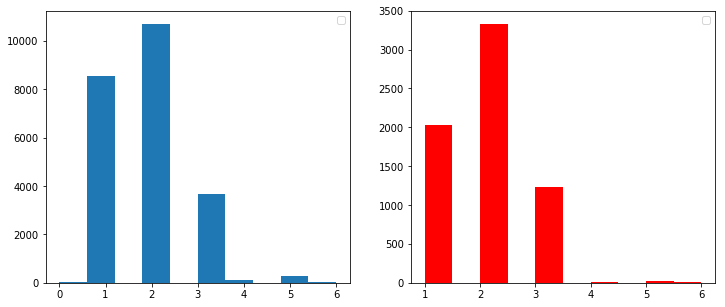

In [117]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default == 0]['EDUCATION'])
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default == 1]['EDUCATION'], color = 'r')
pylab.legend()

pylab.show()

In [112]:
k = []
for i in range(7):
    k.append([data[data['EDUCATION'] == i][data.default == 0].shape[0], data[data['EDUCATION'] == i][data.default == 1].shape[0], data[data['EDUCATION'] == i][data.default == 0].shape[0]+data[data['EDUCATION'] == i][data.default == 1].shape[0]])

C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Se

In [115]:
education = pd.DataFrame(k)
education.columns = ['return','did_not_return','sum']

In [122]:
np.array(education.drop('sum', axis =1))

array([[   14,     0],
       [ 8549,  2036],
       [10700,  3330],
       [ 3680,  1237],
       [  116,     7],
       [  262,    18],
       [   43,     8]], dtype=int64)

Выборки независимы и ожидаемое число наблюдений не принимает значения менее 5 более чем в 20% ячеек, следовательно, воспользуемся критерием хи-квадрат.

$H_0$ - уровень образования не влияет на возврат средств.

$H_1$ - уровень образования влияет.

In [125]:
stats.chi2_contingency(np.array(education.drop('sum', axis =1)))

(163.21655786997073,
 1.2332626245415605e-32,
 6L,
 array([[1.0903200e+01, 3.0968000e+00],
        [8.2435980e+03, 2.3414020e+03],
        [1.0926564e+04, 3.1034360e+03],
        [3.8293596e+03, 1.0876404e+03],
        [9.5792400e+01, 2.7207600e+01],
        [2.1806400e+02, 6.1936000e+01],
        [3.9718800e+01, 1.1281200e+01]]))

Нулевая гипотеза отвергается в сторону двусторонней альтернативы. Причем, корреляция довольно большая и положительная.

In [138]:
stats.chi2_contingency(np.array(education.drop('sum', axis =1)))[3]-np.array(education.drop('sum', axis =1))

array([[  -3.0968,    3.0968],
       [-305.402 ,  305.402 ],
       [ 226.564 , -226.564 ],
       [ 149.3596, -149.3596],
       [ -20.2076,   20.2076],
       [ -43.936 ,   43.936 ],
       [  -3.2812,    3.2812]])

## 4.Задание.

Проверим, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [141]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

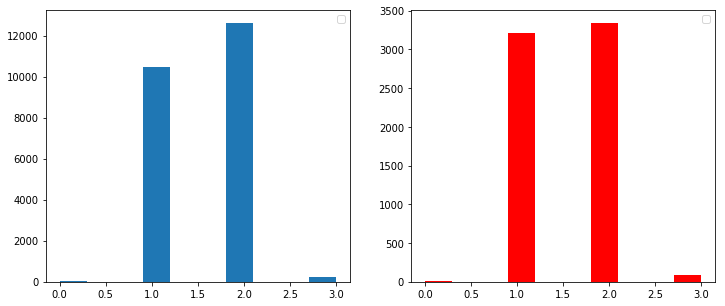

In [142]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default == 0]['MARRIAGE'])
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default == 1]['MARRIAGE'], color = 'r')
pylab.legend()

pylab.show()

Выкинем из выборки объекты, про чье семейное положение мы ничего не знаем.

In [168]:
Data = data[data['MARRIAGE']%3 <> 0]

In [169]:
marriage = pd.DataFrame({'0' : [Data[Data['default'] == 0][Data['MARRIAGE'] == 1].shape[0],Data[Data['default'] == 0][Data['MARRIAGE'] == 2].shape[0]],'1':[Data[Data['default'] == 1][Data['MARRIAGE'] == 1].shape[0],Data[Data['default'] == 1][Data['MARRIAGE'] == 2].shape[0]]})

C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [157]:
marriage ## 0 замужем/женат, 1 холост

,0,1
0,10453,3206
1,12623,3341


Выборки независимы и ожидаемое число наблюдений не принимает значения менее 5 более чем в 20% ячеек, следовательно, воспользуемся критерием хи-квадрат.

$H_0$ - семейное положение не влияет на возврат средств.

$H_1$ - влияет.

In [165]:
stats.chi2_contingency(np.array(marriage))

(27.5094090929579,
 1.5633210355976673e-07,
 1L,
 array([[10640.21483307,  3018.78516693],
        [12435.78516693,  3528.21483307]]))

p-value<0.05, гипотеза отвергается в пользу двусторонней альтернативы.

Посчитаем коэффицент корреляции V-Крамера для пары бинарных признаков, зная значени хи-квадрат:

In [160]:
(stats.chi2_contingency(np.array(marriage))[0]/float(data.shape[0]))**0.5

0.030473764821587788

Корреляция довольно не большая.

## 5. Задание.

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

Делаем аналогично пункту 1.

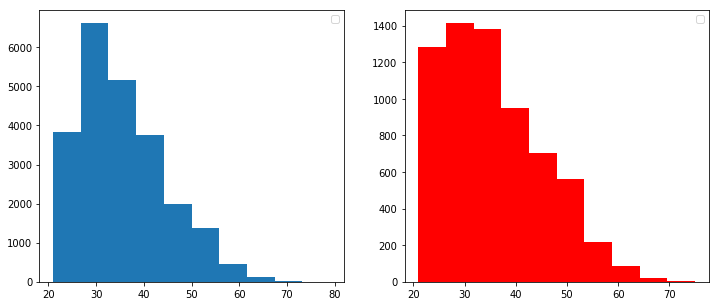

In [172]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default == 0]['AGE'])
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default == 1]['AGE'], color = 'r')
pylab.legend()

pylab.show()

a) С помощью доверительного интревала для разности медиан, проверим нулевую гипотезу о том, что медианы в двух выборках совпадают против двусторонней альтернативы.

In [180]:
np.random.seed(0)

median_0 = map(np.median, get_bootstrap_samples(data[data.default == 0]['AGE'].values, 1000))
median_1 = map(np.median, get_bootstrap_samples(data[data.default == 1]['AGE'].values, 1000))
print "95% confidence interval for the group_0 median :",  stat_intervals(median_0, 0.05)
print "95% confidence interval for the group_1 median:",  stat_intervals(median_1, 0.05)

95% confidence interval for the group_0 median : [34. 34.]
95% confidence interval for the group_1 median: [34. 35.]


In [181]:
print "difference between medians:", np.median(median_0) - np.median(median_1)

difference between medians: 0.0


In [182]:
delta_median = map(lambda x: x[1] - x[0], zip(median_0, median_1))

In [183]:
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median, 0.05)

95% confidence interval for the difference between medians [0. 1.]


Нулевая гипотеза не отвергается.

б) проверим гипотезу о равенстве распределений с помощью рангового критерия Манна-Уитни (так как выборки независимые и в каждой выборке больше 10 объектов), предполагая, что распределения, из которых взяты выборки, полностью совпадают против альтернативы сдвига.

In [177]:
stats.mannwhitneyu(data[data.default == 0]['AGE'], data[data.default == 1]['AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Нулевая гипотеза не отвергается.

Этот результат является практически значимым: распределения возроста в группах примерно одинаковое, следовательно, нельзя сказать, что более молодым людям свойственнее не выплачивать кредит.